In [ ]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/ &> /dev/null
! python -m atari_py.import_roms /content/ROM/ &> /dev/null

--2021-10-10 08:44:09--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   636KB/s    in 18s     

2021-10-10 08:44:27 (613 KB/s) - ‘Roms.rar’ saved [11128004/11128004]



In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install wandb -qqq
import wandb
wandb.init(project='atari-09-10', entity='flexatroid')

Mounted at /content/drive
     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 180 kB 40.4 MB/s 
     |████████████████████████████████| 139 kB 52.7 MB/s 
     |████████████████████████████████| 97 kB 6.0 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import gym
import torch
from skimage.color import rgb2gray
from skimage.transform import rescale
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from collections import deque
import random
import time
from torch.nn.functional import smooth_l1_loss, leaky_relu
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML


%matplotlib inline 
from matplotlib import pyplot as plt

4
Box(0, 255, (210, 160, 3), uint8)
torch.Size([1, 1, 80, 80])
(160, 160)


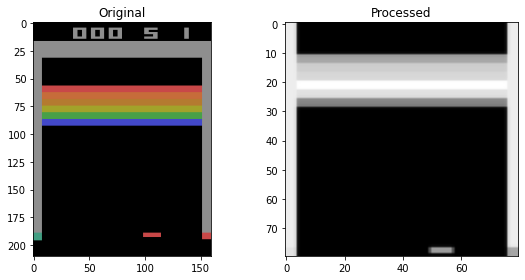

In [ ]:
def process_image(state):
    state = rgb2gray(state[35:195, :, :])
    state = rescale(state, scale=0.5)[np.newaxis, np.newaxis, :, :] 
    return torch.tensor(state)

env = gym.make('BreakoutDeterministic-v4')
print(env.action_space.n)
print(env.observation_space)
state = env.reset()

print((process_image(state)).shape)
print(rgb2gray(state[35:195, :, :]).shape)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(state)
ax[0].set_title("Original")
ax[1].imshow(np.squeeze(process_image(state)), cmap=plt.cm.gray)
ax[1].set_title("Processed")

fig.tight_layout()
plt.show()

In [ ]:
class DeepQNetwork(nn.Module):
    def __init__(self, num_frames, num_actions):
        super(DeepQNetwork, self).__init__()
        self.num_frames = num_frames
        self.num_actions = num_actions

        self.conv1 = nn.Conv2d(
            in_channels=num_frames,
            out_channels=16,
            kernel_size=8,
            stride=4,
            padding=2
            )
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=4,
            stride=2,
            padding=1
            )
        self.fc1 = nn.Linear(
            in_features=3200,
            out_features=256,
            )
        self.fc2 = nn.Linear(
            in_features=256,
            out_features=num_actions,
            )

    def flatten(self, x):
        return x.view(x.size()[0], -1)

    def forward(self, x, k_relu=0.02):
        x = leaky_relu(self.conv1(x), k_relu)
        x = leaky_relu(self.conv2(x), k_relu)
        x = self.flatten(x)                  
        x = leaky_relu(self.fc1(x), k_relu)
        x = self.fc2(x)

        return x

In [ ]:
class DeepQLearningAtari:
    def __init__(self, env, lr=0.0001):
        self.env = env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.action_num = env.action_space.n
        self.state_num = env.observation_space.shape[0]
        self.num_frames = 4
        self.last_info = {'ale.lives': 5}
        self.model = DeepQNetwork(self.num_frames, self.action_num).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def save(self, model_path):
        torch.save(self.model.state_dict(), model_path)  

    def load(self, model_path):
        self.model.load_state_dict(torch.load(model_path))   

    def process_image(self, state):
        state = rgb2gray(state[35:195, :, :])
        state = rescale(state, scale=0.5)[np.newaxis, np.newaxis, :, :] 
        return torch.tensor(state).float().to(self.device)    

    def play(self, train=True, gamma=0.99, eps=0.9, batch_size=32, memory_size=50000, games=3000, model_path="model-atari"):
        def choose_action():
            random_action = random.randint(0, self.action_num - 1)
            if not train and info != self.last_info: return 1
            return random_action if random.random() < eps else output.argmax().item()

        if not train:
          self.load(model_path) 

        memory = deque(maxlen=memory_size)
        state = self.process_image(self.env.reset())

        for game in tqdm(range(games), position=0, leave=True):
            total_reward = 0
            done = False
            info = self.last_info

            if (game % 500 == 0 and game > 0 and train):
                print("Saving model at game ", game)
                self.save(model_path)

            while not done:
                if not train:
                  self.env.render()
                  time.sleep(0.1)   
                while state.size()[1] < self.num_frames:
                    action = 1
                    new_frame, reward, done, _ = self.env.step(action)
                    new_frame = self.process_image(new_frame)
                    state = torch.cat([state, new_frame], 1)
                output = self.model(torch.tensor(state).float())

                action = choose_action()

                self.last_info = info
                next_frame, reward, done, info = self.env.step(action)
                next_frame = self.process_image(next_frame)
                next_state = torch.cat([state, next_frame], 1)[:, 1:, :, :]

                memory.append((state,next_state,reward, done, action))

                total_reward += reward
                if done and train:
                    wandb.log({"total_reward": total_reward})
                    state = self.process_image(self.env.reset())
                else:
                    state = next_state
                
      
                if train and len(memory) > batch_size:
                    batch = list(zip(*random.sample(list(memory), batch_size)))
                    state_batch = torch.cat(batch[0], 0).to(self.device)
                    next_state_batch = torch.cat(batch[1], 0).to(self.device)
                    reward_batch = torch.tensor(batch[2]).to(self.device)
                    done_batch = torch.tensor(batch[3]).to(self.device)
                    action_batch = torch.tensor(batch[4]).to(self.device)

                    with torch.no_grad():
                        target_q, _ = self.model(next_state_batch).max(dim=1)
                        target_q[done_batch] = 0

                    target_q = reward_batch + gamma * target_q

                    q = self.model(state_batch).gather(dim=1, index=action_batch.unsqueeze(dim=1)).squeeze()

                    self.optimizer.zero_grad()
                    smooth_l1_loss(q, target_q).backward()
                    self.optimizer.step()

            eps = max(0.05, eps - eps * (game / games))

        if train:    
          self.save(model_path)

In [ ]:
path = '/content/drive/MyDrive/AdvancedML/breakout/model-09-10'

env = gym.make('BreakoutDeterministic-v4')
dq = DeepQLearningAtari(env)
dq.play(model_path=path, games=3000)
env.close()

 17%|█▋        | 500/3000 [26:33<2:52:15,  4.13s/it]

Saving model at game  500


 33%|███▎      | 1000/3000 [1:05:07<2:44:00,  4.92s/it]

Saving model at game  1000


 50%|█████     | 1500/3000 [1:46:00<1:42:05,  4.08s/it]

Saving model at game  1500


 67%|██████▋   | 2000/3000 [2:27:46<1:20:14,  4.81s/it]

Saving model at game  2000


 83%|████████▎ | 2500/3000 [3:11:56<40:34,  4.87s/it]

Saving model at game  2500


100%|██████████| 3000/3000 [4:00:23<00:00,  4.81s/it]


In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()
env = wrap_env(gym.make('BreakoutDeterministic-v4'))
dq = DeepQLearningAtari(env)
path = '/content/drive/MyDrive/AdvancedML/breakout/model-09-10-night'
dq.play(train=False, games=1, eps=0, model_path=path)
env.close()
show_video()

100%|██████████| 1/1 [00:50<00:00, 50.47s/it]


![Alt text](https://drive.google.com/uc?export=view&id=1YluJbk28CZplmY_EqcoXPKqRgPTOxYPx)

https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf